In [ ]:
!cp "/content/drive/MyDrive/images.zip" "/content"

In [ ]:
!unzip "/content/images.zip" -d "/content"

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
image_dir = Path('/content/images')

filepaths = list(image_dir.glob(r'**/*.jpg') )
filepaths.extend( list(image_dir.glob(r'**/*.jpeg') ))
# filepaths.extend( list(image_dir.glob(r'**/*.webp') ))
# filepaths.extend( list(image_dir.glob(r'**/*.png') ))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(200, random_state=1))
# print(category_samples)
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# image_df

image_df['Label'].value_counts()

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=1.0,rotation_range=45,preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

imgSize = 240
batch_size_num = 64

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(imgSize, imgSize),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=batch_size_num,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(imgSize, imgSize),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=batch_size_num,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(imgSize, imgSize),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=batch_size_num,
    shuffle=False
)

# pretrained_model = tf.keras.applications.MobileNetV2(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='avg'
# )

# pretrained_model.trainable = True

# inputs = pretrained_model.input

# x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
# x = tf.keras.layers.Dense(128, activation='relu')(x)

# outputs = tf.keras.layers.Dense(73, activation='softmax')(x)

# model = tf.keras.Model(inputs, outputs)


# print(model.summary())

# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history = model.fit(
#     train_images,
#     validation_data=val_images,
#     epochs=20,
#     # callbacks=[
#     #     tf.keras.callbacks.EarlyStopping(
#     #         monitor='val_loss',
#     #         patience=3,
#     #         restore_best_weights=True
#     #     )
#     # ]
# )

# results = model.evaluate(test_images, verbose=0)
# print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Found 8176 validated image filenames belonging to 73 classes.
Found 2044 validated image filenames belonging to 73 classes.
Found 4380 validated image filenames belonging to 73 classes.


In [ ]:
learning_rare_num = 0.0001

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    input_shape=(imgSize,imgSize,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True 

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2), # Set higher if over fitting
  tf.keras.layers.Dense(73, activation='softmax')
])

# save model callback
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

# set lr decay callback
def learnDecay(epoch, lr):
    if epoch < (epochsRound / 2):
        return lr
    else:
        return lr * tf.math.exp(-0.1)

learnDecayCallback = tf.keras.callbacks.LearningRateScheduler(learnDecay)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rare_num),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[model_checkpoint_callback, learnDecayCallback]
)

model.load_weights(checkpoint_filepath)
test_loss, test_acc = model.evaluate(test_images, verbose=2)
print(test_acc)

model.save("myTrainingModel.h5")

28467200/28456008 [==============================] - 1s 0us/step
Epoch 1/20
128/128 [==============================] - 210s 2s/step - loss: 4.1186 - accuracy: 0.0685 - val_loss: 3.7200 - val_accuracy: 0.1854 - lr: 1.0000e-04
Epoch 2/20
128/128 [==============================] - 191s 1s/step - loss: 3.1936 - accuracy: 0.2896 - val_loss: 2.6528 - val_accuracy: 0.3982 - lr: 1.0000e-04
Epoch 3/20
128/128 [==============================] - 191s 1s/step - loss: 2.3760 - accuracy: 0.4441 - val_loss: 2.1697 - val_accuracy: 0.4892 - lr: 9.0484e-05
Epoch 4/20
128/128 [==============================] - 191s 1s/step - loss: 1.9289 - accuracy: 0.5335 - val_loss: 1.8902 - val_accuracy: 0.5328 - lr: 8.1873e-05
Epoch 5/20
128/128 [==============================] - 189s 1s/step - loss: 1.6667 - accuracy: 0.5877 - val_loss: 1.7054 - val_accuracy: 0.5832 - lr: 7.4082e-05
Epoch 6/20
128/128 [==============================] - 191s 1s/step - loss: 1.5073 - accuracy: 0.6199 - val_loss: 1.5761 - val_accuracy:

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

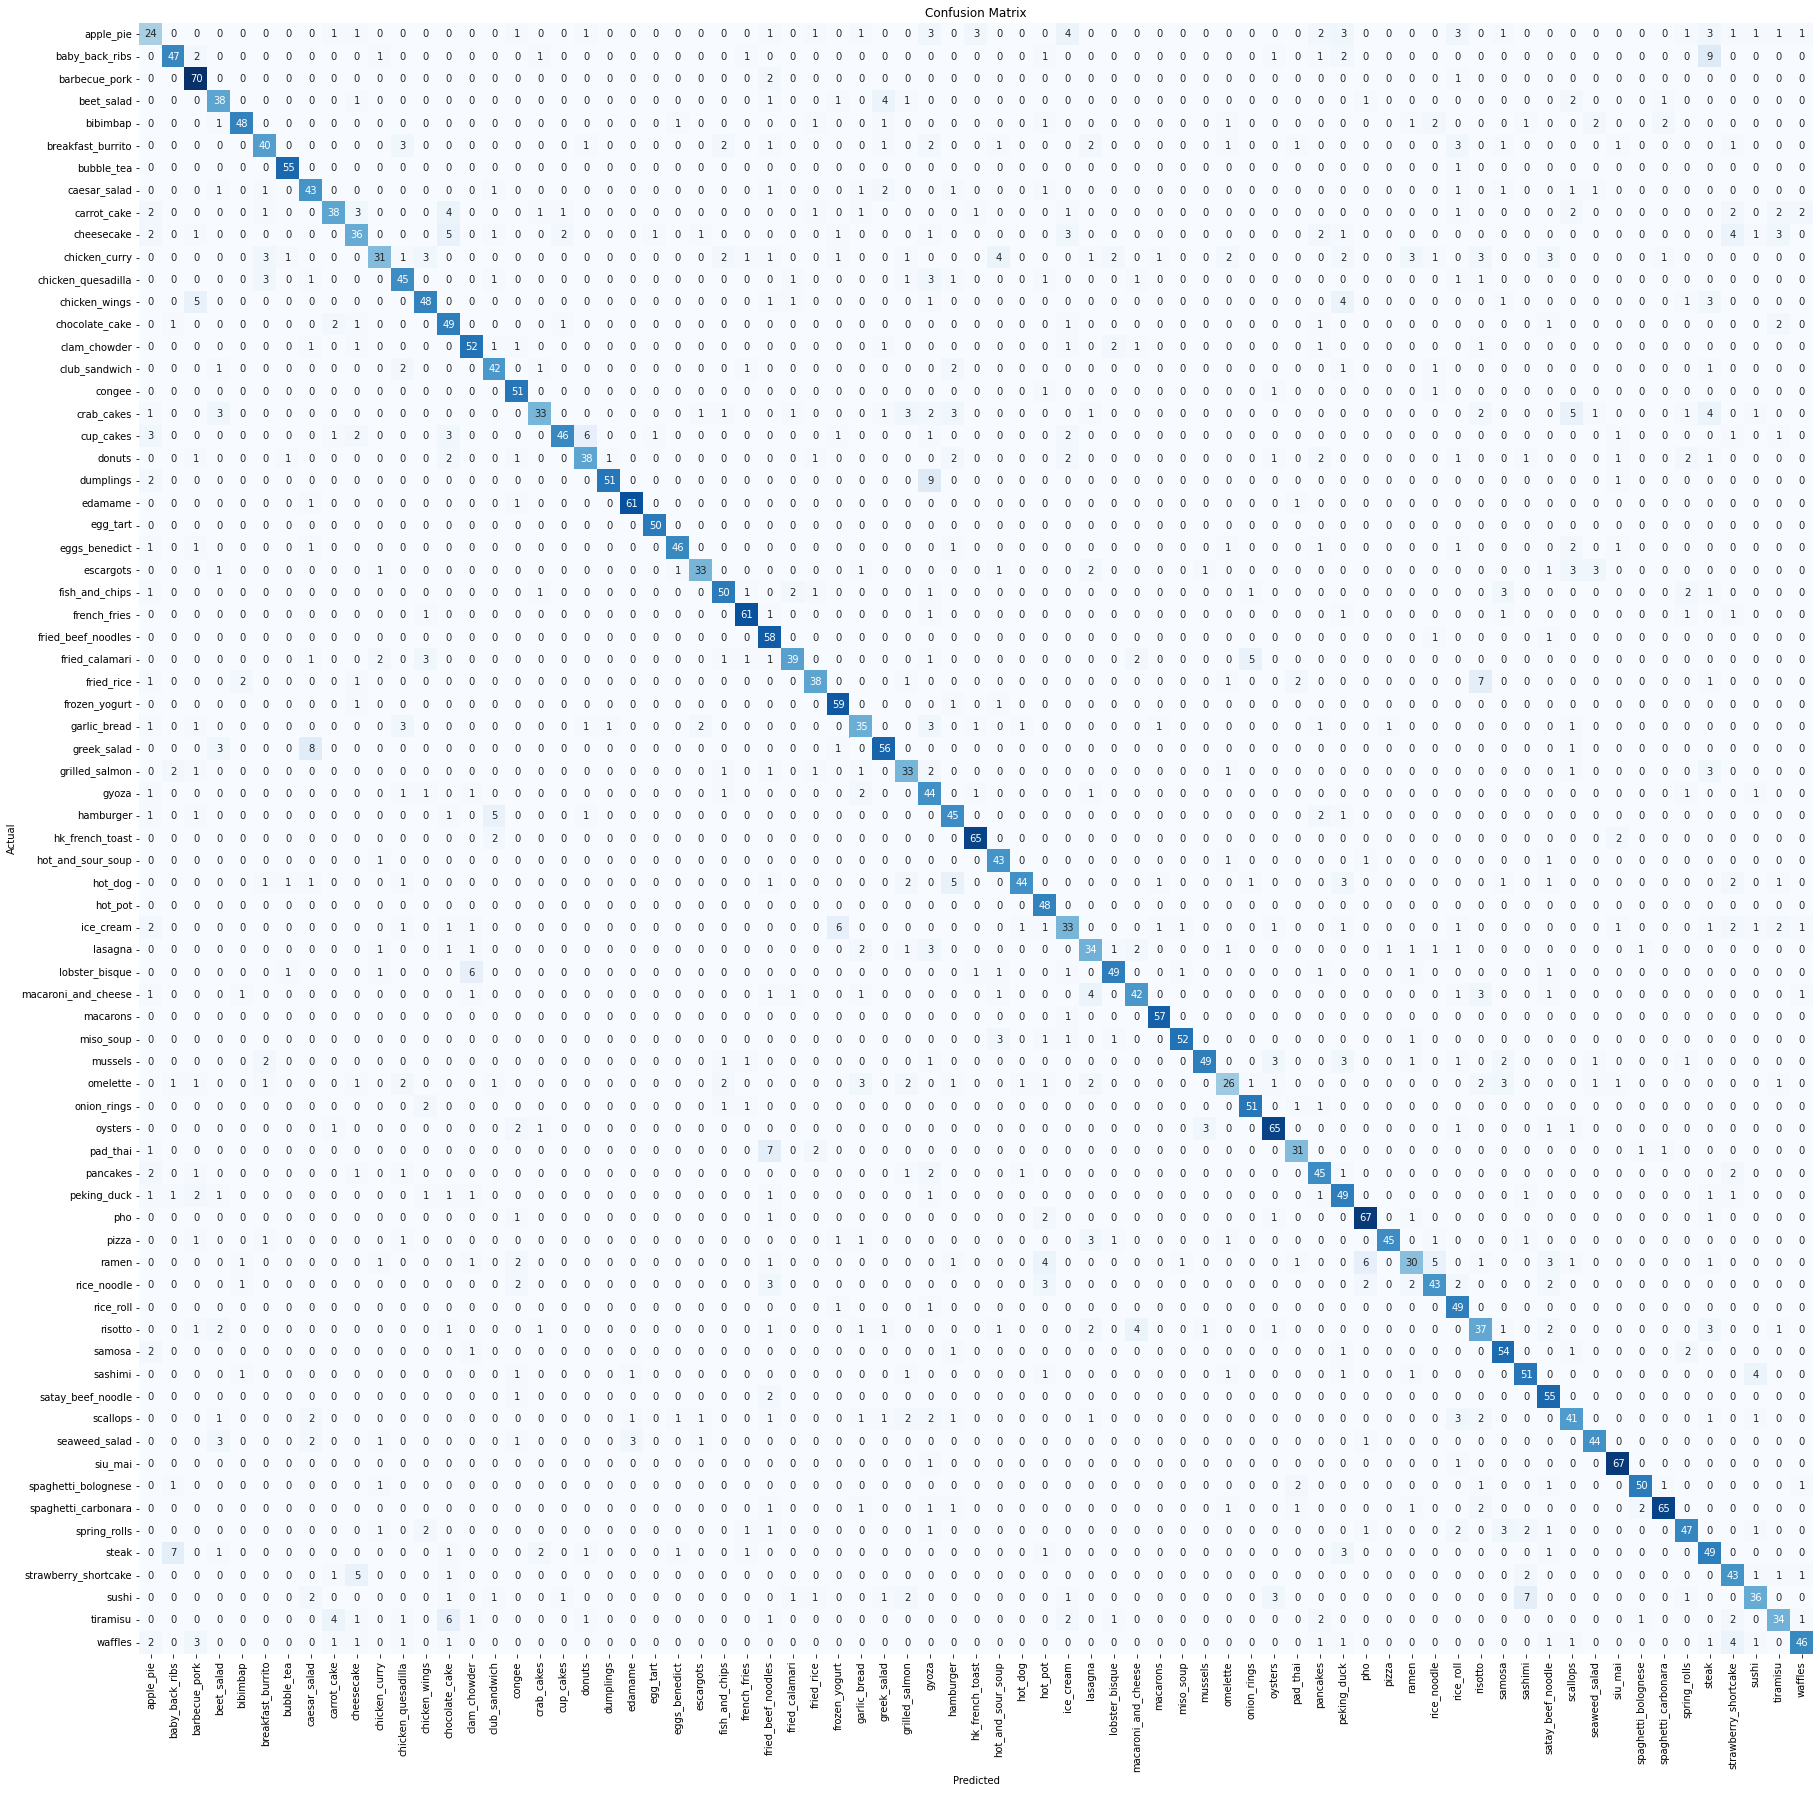

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(73) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(73) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                       precision    recall  f1-score   support

           apple_pie       0.47      0.41      0.44        58
      baby_back_ribs       0.78      0.71      0.75        66
       barbecue_pork       0.76      0.96      0.85        73
          beet_salad       0.68      0.76      0.72        50
            bibimbap       0.89      0.77      0.83        62
   breakfast_burrito       0.75      0.66      0.70        61
          bubble_tea       0.93      0.98      0.96        56
        caesar_salad       0.68      0.77      0.72        56
         carrot_cake       0.78      0.60      0.68        63
          cheesecake       0.64      0.55      0.60        65
       chicken_curry       0.74      0.46      0.56        68
  chicken_quesadilla       0.71      0.75      0.73        60
       chicken_wings       0.79      0.74      0.76        65
      chocolate_cake       0.63      0.83      0.72        59
        clam_chowder  